# Feature Importance in detail

## Are all features needed?

This notebook will examine in depth if all the data being collected is needed to predict the clients target. We will be using a XGBoost classifier to predict the the target and obtain our accuracy scores from.

### Workflow of the process

 1. Import data and libraries
 2. Wrangle data and compute feature importance
 3. Re-construct beginning state of data with 'covariate importance'
 4. Fit XGBoost Classifier with different number of covariates
  * With 5 most feature important
  * With 10 most feature important
  * With 15 most feature important
  * With 20 most feature important
  * With 25 most feature important
  * With 30 most feature important
 5. Plot the Acuuracy with Number of covariates trade-off
 
To run the notebook, make sure you all the appropriate software and libraries downloaded on your local machine.

# Import libraries and data

In [1]:
# Important libraries for data frame manipulations.
import pandas as pd
import numpy as np
import sys as sys

from sklearn.tree import DecisionTreeClassifier

# For fitting a XGBClassifier
from xgboost import XGBClassifier

# To create graphs/plots to visualisation feature relations.
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Reading in the training and testing set already provided.
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")
submit_file = pd.read_csv("data/sample_submission.csv", index_col='id')

# Isolating the response value.
trainY_response = training_data['target'].copy()

# Dropping the values not needed in the datasets
# From training = [targer, id]
# From tesitng = [id]
training_data.drop('target', axis = 1, inplace = True)
testing_data.drop('id', axis = 1, inplace = True)

We need to One-Hote-Encode the training and testing set with the same structure to find the feature importance of each feature in the dataset.

### [2] Wrangle Data and compute importance value of covariates

In [3]:
### FUNCTION that one hot encodes the 2 datasets together.
## Merged dataset will be send and it will be returned 1-Hot-Encoded
def find_one_encoder(train, test):
    ## MERGED DATA
    # This will concatenate the test data rows below the train data
    # The first 300K rows will be the train.
    # The last 200K rows will be the testing.
    merged_encoder = pd.concat([train, test])


    # Using get_dummies() which is the same thing as 1-hot-encoder but ignores numerical values.
    merged_encoder = pd.get_dummies(merged_encoder)
    return(merged_encoder)


# First 300K rows is our training set.
full_train_X_data = find_one_encoder(training_data.copy(),testing_data.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
full_test_X_data = find_one_encoder(training_data.copy(),testing_data.copy()).iloc[300000:,:]

In [4]:
# Checking if the computation was done correctly.
full_train_X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Columns: 643 entries, id to cat18_D
dtypes: float64(12), uint8(631)
memory usage: 210.3 MB


In [5]:
full_test_X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Columns: 643 entries, id to cat18_D
dtypes: float64(12), uint8(631)
memory usage: 140.2 MB


Feature importance will be found using a decision tree. The covariates used to split the data closest to the root have the highest info gain. This means there are more important than others in predicting our target goal.

In [6]:
%%time
# Fitting a random forest with only 5 trees to get feature importance.
DT_feature_importance = DecisionTreeClassifier(criterion='entropy', random_state=5059)
DT_feature_importance.fit(full_train_X_data, trainY_response)

CPU times: user 35 s, sys: 1.49 s, total: 36.5 s
Wall time: 37.9 s


DecisionTreeClassifier(criterion='entropy', random_state=5059)

In [7]:
# Finding the features that are important.
features = []
feature_score = []
# Appenind all scores in arrays to create a data frame.
for i, column in enumerate(full_train_X_data):
    features.append(column)
    feature_score.append(DT_feature_importance.feature_importances_[i])
    
# Create a dataframe with these arrays.
feature_score_df = zip(features, feature_score)
feature_score_df = pd.DataFrame(feature_score_df, columns = ['Feature', 'Feature Score'])

# Sort the data frame according to feature score.
feature_score_df = feature_score_df.sort_values('Feature Score', ascending=False).reset_index()
feature_score_df

,index,Feature,Feature Score
0,632,cat16_B,0.222815
1,6,cont5,0.064849
2,2,cont1,0.048936
3,7,cont6,0.047512
4,5,cont4,0.043646
...,...,...,...
638,383,cat10_DH,0.000000
639,382,cat10_DG,0.000000
640,380,cat10_DE,0.000000
641,379,cat10_DD,0.000000


### [3] Re-construct and find covariate importance

We will find the whole column(covariate) importance of the starting by summing all levels feature importance. We will then subset the datasts, in terms of whole most important covariates for prediction.

In [8]:
# Creating a dictionary to find sum of feature importance scores for each full covariate
covariate_importance = {}
# Loop through all the features
for index, row in feature_score_df.iterrows():
    # Capture only covariate name
    col = row['Feature'].split('_')[0]
    # Capture feature importance score
    score = row['Feature Score']
    # Add the feature importance score with the name in dictionary and append.
    if col in covariate_importance:
        covariate_importance[col] += score
    else:
        covariate_importance[col] = score

# Sort the dictionary according to the dictionary values.
sorted_by_value = sorted(covariate_importance.items(),key=lambda x: x[1], reverse=True)

# Print the dictionary in a presentable way.
for covariate in sorted_by_value:
    print(covariate)  

('cat16', 0.22486957172363686)
('cont5', 0.0648488148141639)
('cont1', 0.04893635600156071)
('cont6', 0.04751204536228715)
('cont4', 0.04364580514968128)
('cont2', 0.042974862608814786)
('cont8', 0.042876331017358466)
('cont3', 0.04280314254448044)
('id', 0.041575329457989973)
('cont9', 0.04005312493535506)
('cont0', 0.039723254284598074)
('cont10', 0.039454475015376037)
('cont7', 0.03807500891209623)
('cat7', 0.02662767003316534)
('cat10', 0.02529424803206638)
('cat8', 0.02382813025380267)
('cat1', 0.0221210901136999)
('cat18', 0.02107364327017766)
('cat0', 0.016921551114809995)
('cat2', 0.015969833618716168)
('cat15', 0.015574059413575325)
('cat14', 0.011888233523265191)
('cat4', 0.011651864598939141)
('cat6', 0.009872855879651707)
('cat11', 0.00881436395636135)
('cat9', 0.008797914696591885)
('cat3', 0.008405162821917571)
('cat17', 0.0067234093454962285)
('cat5', 0.0043530158132720565)
('cat12', 0.0024455332120263858)
('cat13', 0.0022892984750661734)


In [9]:
# Taking the top most important covariates in arrays.
top5 = ['cat16','cont5', 'cont1', 'cont6', 'cont4']
top10 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10']
top15 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10', 'cont0', 'cont7',
        'cat7','cat10', 'cat8' ] 
top20 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10', 'cont0', 'cont7',
        'cat7','cat10', 'cat8', 'cat1','cat18','cat2','cat0','cat15'] 
top25 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10', 'cont0', 'cont7',
        'cat7','cat10', 'cat8', 'cat1','cat18','cat2','cat0','cat15','cat14','cat4', 'cat6','cat9', 'cat3']

# Subseting data to top5 cov
training_5 = training_data[top5].copy()
testing_5 = testing_data[top5].copy()

# Subseting data to top10 cov
training_10 = training_data[top10].copy()
testing_10 = testing_data[top10].copy()

# Subseting data to top15 cov
training_15 = training_data[top15].copy()
testing_15 = testing_data[top15].copy()

# Subseting data to top20 cov
training_20 = training_data[top20].copy()
testing_20 = testing_data[top20].copy()

# Subseting to top25 cov
training_25 = training_data[top25].copy()
testing_25 = testing_data[top25].copy()

### [4] Start trainign XGBoost with different datasets

### For top 5 Covariates


In [10]:
%%time
# First 300K rows is our training set.
top5_train_X_data = find_one_encoder(training_5,testing_5).iloc[:300000,:]
# Last 200K rows is our testing set.
top5_test_X_data = find_one_encoder(training_5,testing_5).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top5_train_X_data, trainY_response)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:10:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 5s, sys: 126 ms, total: 1min 5s
Wall time: 16.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top5_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top5-xgboost.csv')

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**Accuracy Score from Kaggle = 84.741%**

### For top 10 Covariates

In [12]:
%%time
# First 300K rows is our training set.
top10_train_X_data = find_one_encoder(training_10.copy(),testing_10.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top10_test_X_data = find_one_encoder(training_10.copy(),testing_10.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top10_train_X_data, trainY_response)

[21:12:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 9s, sys: 750 ms, total: 2min 10s
Wall time: 38.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top10_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top10-xgboost.csv')

**Accuracy Score from Kaggle = 85.562%**

### For top 15 Covariates

In [14]:
%%time
# First 300K rows is our training set.
top15_train_X_data = find_one_encoder(training_15.copy(),testing_15.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top15_test_X_data = find_one_encoder(training_15.copy(),testing_15.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top15_train_X_data, trainY_response)

[21:14:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 18min 25s, sys: 4.42 s, total: 18min 29s
Wall time: 5min


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top15_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top15-xgboost.csv')

**Accuracy Score from Kaggle = 86.683%**

### For top 20 Covariates

In [16]:
%%time
# First 300K rows is our training set.
top20_train_X_data = find_one_encoder(training_20.copy(),testing_20.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top20_test_X_data = find_one_encoder(training_20.copy(),testing_20.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top20_train_X_data, trainY_response)

[21:20:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 20min 6s, sys: 4.8 s, total: 20min 10s
Wall time: 5min 25s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top20_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top20-xgboost.csv')

**Accuracy Score from Kaggle = 88.104%**

### For top 25 Covariates

In [18]:
%%time
# First 300K rows is our training set.
top25_train_X_data = find_one_encoder(training_25.copy(),testing_25.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top25_test_X_data = find_one_encoder(training_25.copy(),testing_25.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top25_train_X_data, trainY_response)

[21:26:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 22min 20s, sys: 8.12 s, total: 22min 28s
Wall time: 6min 37s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top25_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top25-xgboost.csv')

**Accuracy Score from Kaggle = 88.357%**

### For top 30 Covariates

In [ ]:
%%time 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(full_train_X_data, trainY_response)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(full_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top30-xgboost.csv')

**Accuracy Score from Kaggle = 88.564%**

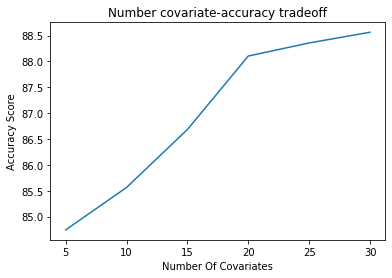

In [29]:
# Putting results in data frame to plot the trade-off.
data = {'Number Of Covariates':  [5, 10, 15, 20, 25, 30],
        'Accuracy Score': [84.741, 85.562, 86.683, 88.104, 88.357,88.564]
        }

trade_off = pd.DataFrame (data, columns = ['Number Of Covariates','Accuracy Score'])

# Plotting data
trade_off_plot = sns.lineplot(data=trade_off, x="Number Of Covariates", y="Accuracy Score")
trade_off_plot.set_title("Number covariate-accuracy tradeoff")
# Saving plot
figure_save = trade_off_plot.get_figure()
figure_save.savefig("trade-off.png")

# Previewing plot
plt.show()